In [1]:
import numpy
import matplotlib.pyplot as plt
import pandas

In [2]:
def sloppyROH (recoMap, target, refHaps, windowSize = 0.001):
    
    # figure out per snp agreement between references and reads from target
    # how many reads agree with reference alleles?
    refAgree = (1-refHaps) * target[0,:]
    # how many reads agree with alternative alleles?
    altAgree = refHaps * target[1,:]
    # the total agreement at each SNP
    totalAgree = refAgree + altAgree
    
    # make a dict that tells you which SNPs fall in a window around the focal SNP
    neighborhood = {}
    for p in range(numSnps):
        # debug print
#         if (p % 10000 == 0):
#             print (p)
        # the map relative to snp p
        relativeMap = recoMap - recoMap[p]
        # the indices of the snps that are in the window around p
        themIndices = numpy.nonzero(abs(relativeMap) < windowSize)
        neighborhood[p] = themIndices
    
    # need total counts per snp too normalize
    countsPerSnp = numpy.sum (target, axis=0)
    
    # now compute the number for every snp using the neighborhoods
    myROH = numpy.zeros(numSnps)
    for p in range(numSnps):
        # debug print
#         if (p % 10000 == 0):
#             print (p)
        # get your window
        daHood = neighborhood[p]
        # total number of reads in this window
        totalReads = numpy.sum(countsPerSnp[daHood])
        # get the agreement with ref haps in this window
        neighborAgreePerSnp = totalAgree[:,daHood]
        # total agreement with each ref hap in this window
        totalNeighborAgree = numpy.sum (neighborAgreePerSnp, axis=2)
        # relative to count number in window
        relativeNeighborAgree = totalNeighborAgree / totalReads
        # and store the max
        myROH[p] = numpy.max (relativeNeighborAgree)
        
    # give it away now
    return myROH

In [3]:
def sloppyROHToo (recoMap, target, refHaps, windowSize = 0.001):
    
    # figure out per snp agreement between references and reads from target
    # how many reads agree with reference alleles?
    refAgree = (1-refHaps) * target[0,:]
    # how many reads agree with alternative alleles?
    altAgree = refHaps * target[1,:]
    # the total agreement at each SNP
    totalAgree = refAgree + altAgree
    
    # what are the bounds of the window around the focal SNP
    firstNeighbor = numpy.searchsorted (recoMap + windowSize, recoMap)
    lastNeighbor = numpy.searchsorted (recoMap - windowSize, recoMap)

    # need total counts per snp too normalize
    countsPerSnp = numpy.sum (target, axis=0)
    
    # now compute the number for every snp using the neighborhoods
    myROH = numpy.zeros(numSnps)
    for p in range(numSnps):
        # debug print
#         if (p % 10000 == 0):
#             print (p)
        # get your window
        begin = firstNeighbor[p]
        end = lastNeighbor[p]
        # total number of reads in this window
        totalReads = numpy.sum(countsPerSnp[begin:end])
        # get the agreement with ref haps in this window
        neighborAgreePerSnp = totalAgree[:,begin:end]
        # total agreement with each ref hap in this window
        totalNeighborAgree = numpy.sum (neighborAgreePerSnp, axis=1)
        # relative to count number in window
        relativeNeighborAgree = totalNeighborAgree / totalReads
        # and store the max
        myROH[p] = numpy.max (relativeNeighborAgree)
        
    # give it away now
    return myROH

In [4]:
def collectWindow (begin, end, totalAgree, countsPerSnp):
    # total number of reads in this window
    totalReads = numpy.sum(countsPerSnp[begin:end])
    # get the agreement with ref haps in this window
    totalNeighborAgree = numpy.sum (totalAgree[:,begin:end], axis=1)
    # return max of agreement relative to count number in window
    return (numpy.max (totalNeighborAgree / totalReads))

In [5]:
def sloppyROHThree (recoMap, target, refHaps, windowSize = 0.001):
    
    # figure out per snp agreement between references and reads from target
    # how many reads agree with reference alleles?
    refAgree = (1-refHaps) * target[0,:]
    # how many reads agree with alternative alleles?
    altAgree = refHaps * target[1,:]
    # the total agreement at each SNP
    totalAgree = refAgree + altAgree
    
    # what are the bounds of the window around the focal SNP
    firstNeighbor = numpy.searchsorted (recoMap + windowSize, recoMap)
    lastNeighbor = numpy.searchsorted (recoMap - windowSize, recoMap)

    # need total counts per snp too normalize
    countsPerSnp = numpy.sum (target, axis=0)
    
    # now compute the number for every snp using the neighborhoods
    myROH = numpy.array([collectWindow (x, y, totalAgree, countsPerSnp) for (x,y) in zip (firstNeighbor, lastNeighbor)])
    
    # give it away now
    return myROH

In [6]:
# vectorized version of collect window
# be sure to exlcude all but first two arguments
vecCollectWindow = numpy.vectorize (collectWindow, excluded=[2,3])

In [7]:
def sloppyROHFour (recoMap, target, refHaps, windowSize = 0.001):
    
    # figure out per snp agreement between references and reads from target
    # how many reads agree with reference alleles?
    refAgree = (1-refHaps) * target[0,:]
    # how many reads agree with alternative alleles?
    altAgree = refHaps * target[1,:]
    # the total agreement at each SNP
    totalAgree = refAgree + altAgree
    
    # what are the bounds of the window around the focal SNP
    firstNeighbor = numpy.searchsorted (recoMap + windowSize, recoMap)
    lastNeighbor = numpy.searchsorted (recoMap - windowSize, recoMap)

    # need total counts per snp too normalize
    countsPerSnp = numpy.sum (target, axis=0)
    
    # now compute the number for every snp using the neighborhoods
    myROH = vecCollectWindow (firstNeighbor, lastNeighbor, totalAgree, countsPerSnp)
    
    # give it away now
    return myROH

In [8]:
# read in posterior
posterior = numpy.loadtxt ("/Users/steinrue/tmp/haraldHAPSBURG/data_matthias/posterior0.csv")

In [9]:
# load some files maybe
# recombination map (in morgan)
recoMap = numpy.loadtxt ("/Users/steinrue/tmp/haraldHAPSBURG/data_matthias/map.csv", delimiter=',')
print (recoMap.shape)
# readcounts for target individual
# first line: reads for ref; second line: reads for alt
target = numpy.loadtxt ("/Users/steinrue/tmp/haraldHAPSBURG/data_matthias/readcounts.csv", delimiter=',')
print (target.shape)
numSnps = target.shape[1]

(38032,)
(2, 38032)


In [10]:
# read in references
refHaps = numpy.loadtxt ("/Users/steinrue/tmp/haraldHAPSBURG/data_matthias/refs.csv", delimiter=',')
print (refHaps.shape)

(792, 38032)


In [11]:
myRoh = sloppyROH (recoMap, target, refHaps)

In [12]:
%%time
myRoh = sloppyROH (recoMap, target, refHaps)

CPU times: user 5.92 s, sys: 505 ms, total: 6.43 s
Wall time: 5.12 s


In [13]:
myRohToo = sloppyROHToo (recoMap, target, refHaps)

In [14]:
%%time
myRohToo = sloppyROHToo (recoMap, target, refHaps)

CPU times: user 2.91 s, sys: 250 ms, total: 3.16 s
Wall time: 1.85 s


In [15]:
myRohThree = sloppyROHThree (recoMap, target, refHaps)

In [16]:
%%time
myRohThree = sloppyROHThree (recoMap, target, refHaps)

CPU times: user 2.89 s, sys: 252 ms, total: 3.14 s
Wall time: 1.85 s


In [17]:
myRohFour = sloppyROHFour (recoMap, target, refHaps)

In [18]:
%%time
myRohFour = sloppyROHFour (recoMap, target, refHaps)

CPU times: user 2.97 s, sys: 251 ms, total: 3.22 s
Wall time: 1.92 s


In [19]:
# where do the observed reads show heterozygosity?
hets = (target[0,:]>0) * (target[1,:]>0)
# smooth it a bit (careful, this does not really use the genetic map)
N = 40
smoothHets = numpy.convolve (hets, numpy.ones (N)/N, mode='same')

In [20]:
th = numpy.min(myRoh) + 0.8 * (numpy.max(myRoh) - numpy.min(myRoh))

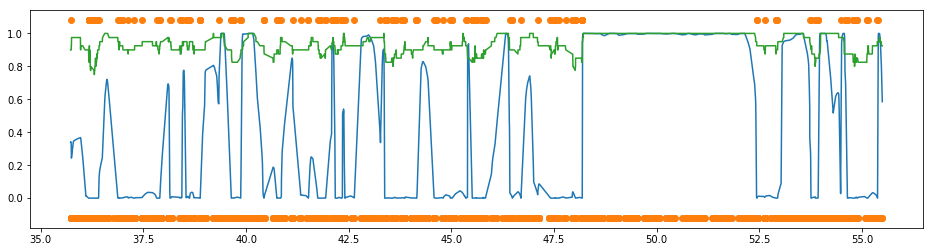

In [21]:
daRange = numpy.arange(5000,8000)
plt.figure (figsize=(16,4))
# plt.plot (recoMap[daRange]*100, myRohToo[daRange],
#           recoMap[daRange]*100, myRoh[daRange]-0.1,
#           recoMap[daRange]*100, myRohThree[daRange]-0.2,
#           recoMap[daRange]*100, myRohFour[daRange]-0.3)
# plt.plot (recoMap[daRange]*100, 1-numpy.exp(posterior[daRange]), recoMap[daRange]*100, myRoh[daRange])
plt.plot (recoMap[daRange]*100, 1-numpy.exp(posterior[daRange]),
          recoMap[daRange]*100, (hets[daRange]-0.1)*1.2, "o",
          recoMap[daRange]*100, 1-smoothHets[daRange])
# plt.plot (recoMap[daRange]*100, 1-numpy.exp(posterior[daRange])>0.8, recoMap[daRange]*100, (myRoh > th)[daRange])
# plt.plot (recoMap[daRange]*100, 1-numpy.exp(posterior[daRange])>0.8, recoMap[daRange]*100, (myRoh > th)[daRange], recoMap[daRange]*100, (hets[daRange]-0.1)*1.2, "o")
# plt.plot (recoMap[daRange]*100, 1-numpy.exp(posterior[daRange])>0.8, recoMap[daRange]*100, (myRoh > th)[daRange])


In [22]:
# get some truth
truthTable = pandas.read_csv ("/Users/steinrue/tmp/haraldHAPSBURG/data_matthias/roh_gt.csv", sep='\t')

In [23]:
truthTable

,ROH_Begin,ROH_End,iid,copyiid,chr
0,0.002675,0.042675,iid0,NA20797,3
1,0.481866,0.521866,iid0,NA20778,3
2,1.078672,1.118672,iid0,NA20797,3
3,1.676946,1.716946,iid0,NA20509,3
4,2.074746,2.114746,iid0,NA20772,3


In [24]:
# make a truth vector
truth = numpy.zeros (numSnps)
beginnings = numpy.searchsorted (recoMap, truthTable["ROH_Begin"])
ends = numpy.searchsorted (recoMap, truthTable["ROH_End"])
assert (len(beginnings) == len(ends))
for i in range(len(beginnings)):
    truth [beginnings[i]:ends[i]] = 1

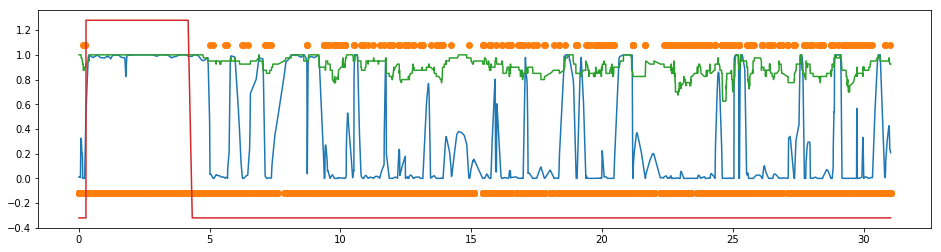

In [25]:
daRange = numpy.arange(0,4000)
plt.figure (figsize=(16,4))
plt.plot (recoMap[daRange]*100, 1-numpy.exp(posterior[daRange]),
          recoMap[daRange]*100, (hets[daRange]-0.1)*1.2, "o",
          recoMap[daRange]*100, 1-smoothHets[daRange],
          recoMap[daRange]*100, (truth[daRange]-0.2)*1.6)

In [26]:
numpy.corrcoef (truth, 1-numpy.exp(posterior))

array([[1.        , 0.47893864],
       [0.47893864, 1.        ]])

In [27]:
numpy.corrcoef (truth, myRohFour)

array([[1.        , 0.38745438],
       [0.38745438, 1.        ]])

In [28]:
newRoh = myRohFour = sloppyROHFour (recoMap, target, refHaps, 0.004)
numpy.corrcoef (truth, myRohFour)

array([[1.        , 0.46184588],
       [0.46184588, 1.        ]])

In [29]:
numpy.corrcoef (truth, hets)

array([[ 1.        , -0.09936183],
       [-0.09936183,  1.        ]])

In [30]:
numpy.corrcoef (truth, smoothHets)

array([[ 1.        , -0.38796539],
       [-0.38796539,  1.        ]])

In [31]:
N = 800
smoothHets = numpy.convolve (hets, numpy.ones (N)/N, mode='same')
numpy.corrcoef (truth, smoothHets)

array([[ 1.        , -0.67141974],
       [-0.67141974,  1.        ]])

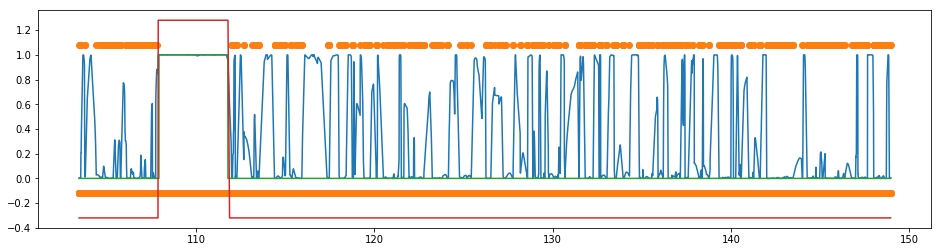

In [32]:
daRange = numpy.arange(18000,28000)
plt.figure (figsize=(16,4))
plt.plot (recoMap[daRange]*100, 1-numpy.exp(posterior[daRange]),
          recoMap[daRange]*100, (hets[daRange]-0.1)*1.2, "o",
          recoMap[daRange]*100, (1-smoothHets[daRange])>0.967,
          recoMap[daRange]*100, (truth[daRange]-0.2)*1.6)